In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/assignment2

/content/drive/My Drive/assignment2


# Data Preprocessing

**Dataset : Lung Nodule**

**[ What is the lung nodule? ]**                     
A lung nodule (or mass) is a small globular lesion that is sometimes found during a CT scan of the chest. It is less than 3 cm in diameter within the lung.These scans are done for many reasons, such as part of lung cancer screening, or to check the lungs if you have symptoms.

Most lung nodules seen on CT scans are not cancer. They are more often the result of old infections, scar tissue, or other causes. But tests are often needed to be sure a nodule is not cancer.


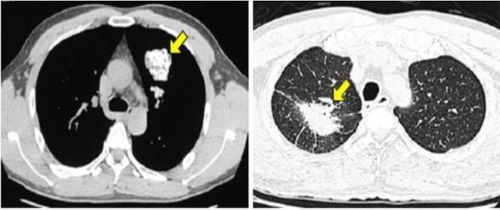

The figure on the *left* is a **benign lung nodule** chest CT image, and the *right* is a **malignant lung nodule** image.
When the size of the lesion is 3cm or more in diameter, it is called a'lung tumor' or a'lump' rather than a nodule. There is no symptom, so it is found by X-ray scan or CT during medical examination. It is known that about 35% of all adults with lung nodules are the cause of malignant tumors. If a lung nodule is found, the size of the lung nodule should be compared by viewing a chest image taken at least 2 years. If there is no change in the size of the nodule, it is benign and you can observe the progress without any treatment, but in malignant cases, the nodule grows twice as large within 30 to 400 days, so if the size of the nodule increases, it should be removed immediately by surgery.

**[ Purpose of the Tasks ]**      
However, it is a problem if there are no past radiographic results. This is because the growth trend of the nodule is unknown. In this case, the doctor should judge the shape of the nodule by looking at the chest CT image. In addition, even if it is positive, CT scans should be taken periodically to observe the progress. Therefore, if we create a model that can detect (classify) lung nodules as benign/malignant through the test, we will be able to reduce the burden of diagnosis and prevent lung cancer in advance.

**A vital first step in the analysis of lung cancer screening CT scans is the detection of pulmonary nodules, which may or may not represent early stage lung cancer.**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
from matplotlib import pyplot as plt
import torch.nn.init as init
from torchvision import transforms
from PIL import Image

In [ ]:
dat = np.load("trn_dat.npy") #Should contain (2800,32,32,16) float32 numpy array
lbl = np.load("trn_lbl.npy") #Should contain (2800,) boolean numpy array

In [ ]:
#Normalize
def normalize(x):
    min = -1000
    max = 500
    x[x < min] = min
    x[x > max] = max
    x = (x - min) / (max - min)
    x = x.astype("float32")
    return x

In [ ]:
#Normalizing and transpose
data= normalize(dat)
print(data.shape)
data = np.transpose(data, (0,3,1,2))
print(data.shape)

(2800, 32, 32, 16)
(2800, 16, 32, 32)


In Pytorch, tensor is *(batch, channel, height, width)*, so I changed the dimension of tensor.           
(batch, height, width, channel) -> (batch, channel, height, width),

In [ ]:
flip_h = transforms.RandomHorizontalFlip(p=1)
flip_v = transforms.RandomVerticalFlip(p=1)

In [ ]:
unloader = transforms.ToPILImage()

def tensor_to_PIL(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    return image

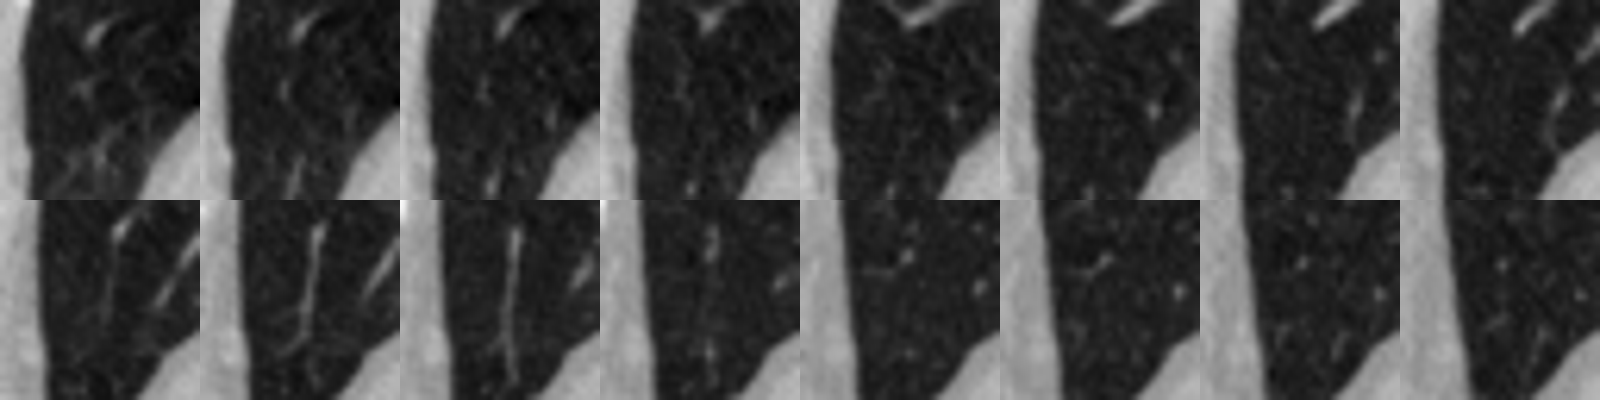

In [ ]:
merged = Image.new('L', (200 * 8, 200 *2))
k = 1000
for i in range(16):
  if i < 8 :
    a = data[k][i]
    a =torch.tensor(a, dtype= torch.float32).unsqueeze(0)
    image = tensor_to_PIL(a)
    resize_image = image.resize((200,200))
    #resize_image = flip_h(resize_image)
    w = 200*i
    merged.paste(resize_image, (w, 0))
  else :
    a = data[k][i]
    a =torch.tensor(a, dtype= torch.float32).unsqueeze(0)
    image = tensor_to_PIL(a)
    resize_image = image.resize((200,200))
    
    w = 200*(i-8)
    merged.paste(resize_image, (w, 200))

display(merged)

It is a plot of the image taken by one patch. Whether it is malignant or benign cannot be distinguished when we see it, and can only be distinguished by a diagnosis of a pathologist. 

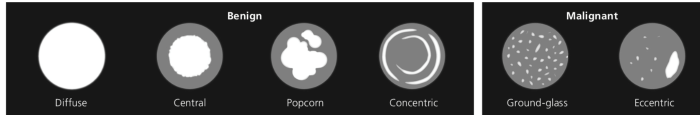

Above figure is the patterns of calcification that suggest benign or malignant lung nodules. Diffuse, Central, Popcorn, Concentric shape is mostly benign, and malignant is like Ground-glass or Eccentric. Doctors look at the above characteristic shapes to determine whether they are malignant or benign. 

In [ ]:

x_train, x_valid, y_train, y_valid = train_test_split(data,
                                                      lbl,
                                                      test_size = 0.1,
                                                      shuffle = True)


In [ ]:

class getDataset(Dataset):

  def __init__(self, x, y):
    
    self.x_train = torch.tensor(x, dtype= torch.float32)#.unsqueeze(1)
    self.y_train = torch.LongTensor(y)
    
    
  def __len__(self):
    return len(self.y_train)

  def __getitem__(self, idx):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    return self.x_train[idx].to(device), self.y_train[idx].to(device)


#Model Architecture 

In [ ]:
class Net2D(nn.Module):
  def __init__(self, num_classes=2):
    super(Net2D, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer3 = nn.Sequential(
        nn.Conv2d(128,256, kernel_size=3, stride=1, padding=2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
        
    self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(6400, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes),
        )
    
    
  def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)
      out = out.reshape(out.size(0), -1)
      #print(out.size())
      out = self.classifier(out)
      
      return out


In [ ]:

class Net3D(nn.Module):
  
  def __init__(self):
    super(Net3D, self).__init__()
    self.conv1 = self.Conv_layer(1, 16)
    self.conv2 = self.Conv_layer(16, 16)
    self.conv3 = self.Conv_layer(32, 64)

    self.fc4 = nn.Linear(16, 16)
    self.relu = nn.ReLU()
    self.fc5 = nn.Linear(150528, 2)

  def Conv_layer(self,input,output):
    conv = nn.Sequential(nn.Conv3d(input, output, kernel_size=(3, 3, 3), padding=0),
                          nn.LeakyReLU(),
                          nn.Conv3d(output, output, kernel_size=(3, 3, 3), padding=1),
                          nn.LeakyReLU())
    return conv

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(x.size(0), -1)
    #print(x.size())
    x = self.fc5(x)
    x = F.log_softmax(x)
    
    return  x

In [ ]:
model = Net2D()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00001)
num_epochs = 100
train_batch = 64
valid_batch = 64
num_train = x_train.shape[0]
num_valid = x_valid.shape[0]
# conv2 : 0.00001 / 500 / 32/64
###########################################################

train_dataset = getDataset(x_train, y_train)
validation_dataset = getDataset(x_valid, y_valid)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= train_batch, shuffle = True)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size= valid_batch, shuffle = False)

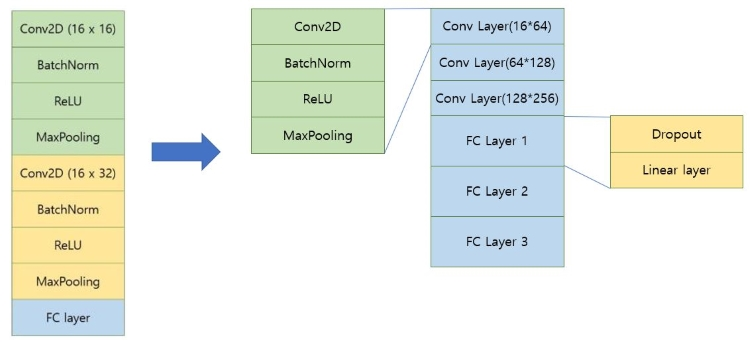

[Architecture Overview]               
The architecture on the left is a basic deep neural network that was first created. When training with this model, the validation loss was *0.4 ~ 0.35* and the accuracy was about *85%*. The structure on the right was made by increasing the number of channels. Two more fully-connected layers and one more convolution layer block were added. As a result, validation loss was about *0.25 ~ 0.20*, and accuracy rose to ***92%***.


[Limitation of 3D Convolution]            
Since the size of the data is 32x32 per image, the model that is too deep has rather poor performance. Data are images of 2800 subjects with a height and width of 32x32 and a channel of 16. Also, considering the data as a 32x32x16 voxel, I tried 3D convolution. In order to do 3d condolution, one more dimension is needed, so I increased the channel dimension with *unsqueeze()*. However, 3d convolution is also inferior in performance to 2d, and the computational cost is too many, so an error of *'error: cuda out of memory'* occurs frequently.






## Traning and Evaluation

In [ ]:
def train(model, train_loader,val_loader, criterion, optimizer, num_train, num_valid, num_epochs):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model.to(device)
  print('==> Training model..')
  loss_values = []
  val_values = []

  for epoch in range(num_epochs):
    
    running_loss = 0.0
    running_corrects = 0
    val_running_loss = 0.0
    val_running_correct =0
    
    model.train()

    for inputs, labels in train_loader:
      optimizer.zero_grad()
      #inputs = inputs.to(device)
      #labels = labels.to(device)
      
      output = model(inputs)
      
      
      loss = criterion(output, labels)
      _, predict = torch.max(output,1)
      
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      running_corrects += torch.sum(predict == labels.data) 
    epoch_loss = running_loss / (num_train / train_batch)
    epoch_acc = running_corrects.double() / num_train * 100
    loss_values.append(epoch_loss)

    #validate
    model.eval()
    with torch.no_grad():
      for val_x, val_y in val_loader:
        val_output = model(val_x)
      
        val_loss = criterion(val_output, val_y)
        _, val_predict = torch.max(val_output, 1)

        val_running_loss += val_loss.item()
        val_running_correct += torch.sum(val_predict == val_y.data) 
        

      val_epoch_loss = val_running_loss / (num_valid / valid_batch)
      val_epoch_acc = val_running_correct.double() / num_valid * 100
      val_values.append(val_epoch_loss)
    
    #if ((epoch + 1) % 10 == 0):
    print("===================================================")
    print('Epoch {}/{}'.format(epoch +1, num_epochs ))
    print("training loss: {:.5f}, acc: {:5f}".format(epoch_loss, epoch_acc))
    print("validation loss: {:.5f}, acc: {:5f}".format(val_epoch_loss, val_epoch_acc))
    plt.plot(np.array(loss_values), 'r')
    plt.plot(np.array(val_values), 'b')


In [ ]:
train(model,
      train_loader,
      val_loader,
      criterion,
      optimizer,
      num_train,
      num_valid,
      num_epochs)

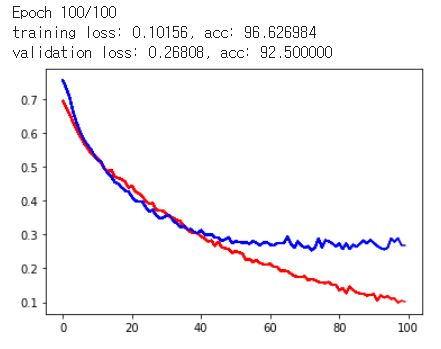

This task is to create a model that classifies the patch images of lung nodules as data. Since 200 images were not known as test images, the training data was randomly split and made into an evaluation set. Evaluation data were randomly created, so when comparing the performance of different models, the data was fixed and training was performed.         
In conclusion, when looking at the graph above, it can be seen that the validation accuracy shows good performance around 90% on average. Through this, we created a model that can accurately distinguish 9 out of 10 patch images. In fact, for medical data, recall is more important than accuracy. This is because it is a very dangerous situation to diagnose that it is not malicious when it is actually malicious. If I use more recent models(resnet and densenet) or implement 3D convolution more, it can be improved better performance.

In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "/content/drive/MyDrive/assignment2/model.pt")